In [38]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

Load csv file as np.array

In [2]:
def load_data():
    with open('pima-indians-diabetes.csv') as f: 
        raw_data = np.array([line.split(",")[:-1] for line in f])
        columns = raw_data[0]
        data = raw_data[1:]
    return columns,data.astype(float)

Split dataset according to holdout validation

In [3]:
def test_train_split(data,fraction):
    n_entries = len(data)
    n_train = int(fraction*n_entries)
    
    indicies = np.random.permutation(np.arange(n_entries))

    train_set = data[indicies[:n_train]]
    test_set = data[indicies[n_train:]]
    
    return train_set, test_set

In [4]:
class NaiveBayesPredictor():
    
    def __init__(self,data):
        self.data = data
        self.calculate_prior()
        self.calculate_mean_and_std()
         
    def predict(self,values):
        prob_class_0 = self.calc_probabilities(values,0)*self.prior[0]
        prob_class_1 = self.calc_probabilities(values,1)*self.prior[1]
   
        if(prob_class_0 > prob_class_1):
            return 0
        else:
            return 1
        
        
    def test(self,test_data):
        n_correct = 0
        n_false = 0
        
        for data_point in test_data:
            correct_class = data_point[-1]
            estimated_class = self.predict(data_point[:-1])
            
            if(correct_class == estimated_class):
                n_correct += 1
            else:
                n_false += 1

        print("{:.1f}% correct".format(100*n_correct/(n_correct+n_false)))
    
    def calculate_prior(self):
        n_datapoints = len(self.data)
        n_class_0 = len(self.data[self.data[:,-1] == 0])
        
        self.prior = np.array([n_class_0, n_datapoints-n_class_0])/n_datapoints
        
    def calculate_mean_and_std(self):
        class_0 = self.data[self.data[:,-1] == 0]
        class_1 = self.data[self.data[:,-1] == 1]
    
        self.mean = [np.mean(class_0, axis=0)[:-1], np.mean(class_1, axis=0)[:-1]]
        self.std = [np.std(class_0, axis=0)[:-1], np.std(class_1, axis=0)[:-1]] 
    
    # Assume features is of Gaussian distribution, and compute PDF
    def calc_probabilities(self,x,c):
        exponent = np.exp( - np.power(x-self.mean[c],2) / (2*np.power(self.std[c],2)) )
        feature_probabilities = exponent / (math.sqrt(2*math.pi) * self.std[c]) 
        
        return np.prod(feature_probabilities)

In [5]:
columns, data = load_data()
print(columns)

['Number_pregnant' 'Glucose_concentration' 'Blood_pressure' 'Triceps'
 'Insulin' 'BMI' 'Pedigree' 'Age' 'Class']


Normalize data

In [6]:
data[:,:-1] = (data[:,:-1]-np.mean(data[:,:-1],axis=0))/np.std(data[:,:-1],axis=0)

In [25]:
train_set,test_set = test_train_split(data,0.67)

In [26]:
c = NaiveBayesPredictor(train_set)

In [27]:
c.test(test_set)

72.8% correct


## Try to improve results with SVD

In [10]:
u,s,v = np.linalg.svd(data[:,:-1])

In [11]:
print(s)

[ 40.10590727  36.4632608   28.12037943  25.9307984   24.19670408
  22.89669413  17.95602478  17.62460929]


## Try keeping just the first few: 

In [12]:
n_cols_to_retain = 3; 
tmp = np.dot(u[:,:n_cols_to_retain],np.diag(s[:n_cols_to_retain]))
svd_data = np.dot(tmp,v[:n_cols_to_retain,:])

In [34]:
reduced_data = np.append(svd_data, data[:,-1].reshape([768,1]),axis = 1)

In [35]:
reduced_data_train,reduced_data_test = test_train_split(reduced_data,0.67)

In [36]:
c_reduced = NaiveBayesPredictor(reduced_data_test)

In [37]:
c.test(reduced_data_test)

73.2% correct


## Try decomposition: 

In [17]:
n_cols_to_retain = 2; 

In [18]:
decomposed_data = np.append(u[:,:n_cols_to_retain],data[:,-1].reshape([768,1]),axis = 1)

In [19]:
decomposed_data_train,decomposed_data_test = test_train_split(decomposed_data,0.67)

In [20]:
c_decomposed = NaiveBayesPredictor(decomposed_data_train)

In [21]:
c_decomposed.test(decomposed_data_test)

68.1% correct


In [22]:
class_0 = decomposed_data[decomposed_data[:,-1] == 0][:,:2]
class_1 = decomposed_data[decomposed_data[:,-1] == 1][:,:2]

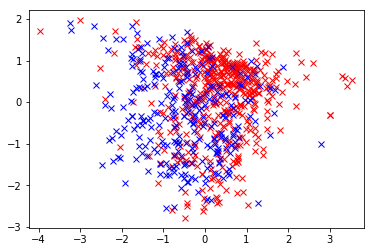

In [137]:
plt.plot(class_0[:,0],class_0[:,1],'rx')
plt.plot(class_1[:,0],class_1[:,1],'bx')
plt.axis('equal')
plt.show()

In [40]:
columns

array(['Number_pregnant', 'Glucose_concentration', 'Blood_pressure',
       'Triceps', 'Insulin', 'BMI', 'Pedigree', 'Age', 'Class'],
      dtype='<U21')

## Try principal component analysis

In [94]:
A = data[:,:-1]
A_T = np.transpose(A); 

M = np.dot(A_T,A)

w,v = np.linalg.eig(M)

In [95]:
print(w/np.sum(w))

[ 0.26179749  0.21640127  0.05247702  0.05055776  0.08532855  0.09529305
  0.10944113  0.12870373]


In [96]:
#Leave out all vectors not correspongint to more than 10 %
v_reduced = v[:,w/np.sum(w)>0.1]
np.shape(v_reduced)

(8, 4)

In [97]:
reduced_data_unlabeled = np.dot(data[:,:-1],v_reduced)
reduced_data = np.append(reduced_data_unlabeled,data[:,-1].reshape([768,1]),axis = 1)

In [98]:
# ReNormalize
reduced_data[:,:-1] = (reduced_data[:,:-1]-np.mean(reduced_data[:,:-1],axis=0))/np.std(reduced_data[:,:-1],axis=0)

In [99]:
train_set_PCA, test_set_PCA = test_train_split(reduced_data,0.67)

In [100]:
c_PCA = NaiveBayesPredictor(train_set_PCA)

In [101]:
c_PCA.test(test_set_PCA)

74.4% correct


## Try to retain only first two for visualization purposes

In [104]:
v_2 = v[:,:2]

In [106]:
reduced_data_unlabeled_2 = np.dot(data[:,:-1],v_2)
reduced_data_2 = np.append(reduced_data_unlabeled_2,data[:,-1].reshape([768,1]),axis = 1)

In [107]:
reduced_data_2[:,:-1] = (reduced_data_2[:,:-1]-np.mean(reduced_data_2[:,:-1],axis=0))/np.std(reduced_data_2[:,:-1],axis=0)

In [108]:
np.shape(reduced_data_2)

(768, 3)

In [109]:
class_0 = reduced_data_2[reduced_data_2[:,-1]==0][:,:2]
class_1 = reduced_data_2[reduced_data_2[:,-1]==1][:,:2]

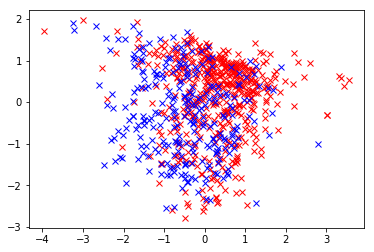

In [110]:
plt.plot(class_0[:,0],class_0[:,1],'rx')
plt.plot(class_1[:,0],class_1[:,1],'bx')
plt.show()

## What happens if you perform SVD on reduced?

In [117]:
u,s,v = np.linalg.svd(reduced_data[:,:-1])

In [118]:
s

array([ 27.71281292,  27.71281292,  27.71281292,  27.71281292])

## Plot decision boundary

In [124]:
train_set, test_set = test_train_split(reduced_data_2,0.67)
classifier = NaiveBayesPredictor(train_set)

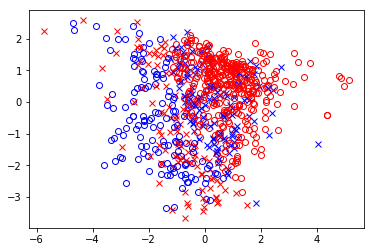

In [133]:
class_0_corr = []
class_0_false = []
class_1_corr = []
class_1_false = []
for item in data:
    c = item[-1]
    transformed = np.dot(item[:-1],v_2)
    c_hat = classifier.predict(transformed); 
    
    if c == c_hat:
        if(c_hat == 0):
            plt.plot(transformed[0],transformed[1],'ro',markerfacecolor='none')
        else:
            plt.plot(transformed[0],transformed[1],'bo',markerfacecolor='none')
    else:
        if(c_hat == 0):
            plt.plot(transformed[0],transformed[1],'bx')
        else:
            plt.plot(transformed[0],transformed[1],'rx')
    
plt.show()
    

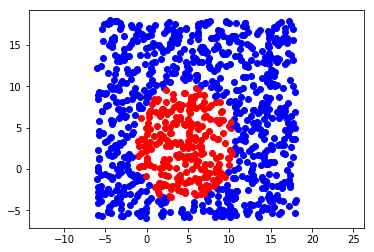

In [141]:
for i in range(1000):
    x=-6+ 24*np.random.rand()
    y=-6 + 24*np.random.rand()
    
    c = classifier.predict([x,y])
    if(c == 0):
        plt.plot(x,y,'ro')
    else:
        plt.plot(x,y,'bo')
        
plt.axis('equal')        
plt.show()